# 1- Import Libraries & Setup Kernel

In [1]:
# Librerías de Dataset y procesamiento
import pandas as pd
import numpy as np
from datetime import datetime

# Librerías para plotear
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# Configuración de Pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Importar NLP
import nltk
#nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopWords = set(stopwords.words('english'))

---
# 2- Import & Explore of the Dataset

In [2]:
# Crear un DataFrame llamado "data" para importar el CSV
data = pd.read_csv('../data/OnlineRetail.csv', header=0, encoding = 'unicode_escape')

---
## 2.a- Descriptive Data Analysis

In [3]:
# Visualizar el Dataset
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


El Dataset contiene productos comprados, agrupados por factura y por cliente.
<br><br>Contiene 8 variables:

- **Numericas**
    - Continuas: UnitPrice 
    - Discretas: Quantity

- **Categoricas**
    - Ordinales:
    - Nominales: CustomerID, InvoiceNo, Description, StockCode, Country
- **Otras**
    - Fecha: InvoiceDate

---
## 2.b- Exploratory Data Analysis

In [4]:
# Visualizar cantidad de filas y columnas
print("Filas: ", data.shape[0], '\nColumnas: ', data.shape[1])

Filas:  541909 
Columnas:  8


In [5]:
# Tipo de variables y valores nulos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Las variables _Description_ y _CustomerID_ contienen valores nulos.

- Description: 1.454 null
- CustomerID: 135.080 null

In [6]:
# Detalles estadísticos básicos
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


Las variables Numéricas _Quantity_ y _UnitPrice_ contienen valores negativos. (Evaluar que hacer con estos datos)

In [7]:
# Detalles de las variables no numericas
data.describe(include=['O']).T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


In [8]:
# Unic CustomerID
UnicCustomerID = len(data.CustomerID.unique())

# Unic InvoiceNo
UnicInvoiceNo =  len(data.InvoiceNo.unique())

print('''Unique Customers:''', UnicCustomerID)
print('''Unique Invoices:''', UnicInvoiceNo)
print('== == == == == == == ==')
print('Avg. Invoices per Customer:', round(UnicInvoiceNo/UnicCustomerID))
print('Avg. Products per Invoice:', round(len(data.Description)/UnicInvoiceNo))
print('Avg. Total Products per InvoiceNo:', round(sum(data.Quantity)/UnicInvoiceNo))

Unique Customers: 4373
Unique Invoices: 25900
== == == == == == == ==
Avg. Invoices per Customer: 6
Avg. Products per Invoice: 21
Avg. Total Products per InvoiceNo: 200


---
### 2.b.a- Explore InvoiceNo field

In [9]:
# Make DataFrame with uniques InvoicesNo
list_invoices = data.groupby(['InvoiceNo', 'CustomerID']).InvoiceNo.agg(['count']).reset_index()

# Create column with the first digit of invoices
list_invoices['FisrtDigit'] = list_invoices['InvoiceNo'].apply(lambda x: x[:1])

# Create column with the last digit of invoices
list_invoices['LastDigit'] = list_invoices['InvoiceNo'].apply(lambda x: x[-1:])

# Create column with the first digit of invoices
list_invoices['NumDigits'] = list_invoices['InvoiceNo'].apply(lambda x: len(x))

list_invoices.head()

,InvoiceNo,CustomerID,count,FisrtDigit,LastDigit,NumDigits
0,536365,17850.0,7,5,5,6
1,536366,17850.0,2,5,6,6
2,536367,13047.0,12,5,7,6
3,536368,13047.0,4,5,8,6
4,536369,13047.0,1,5,9,6


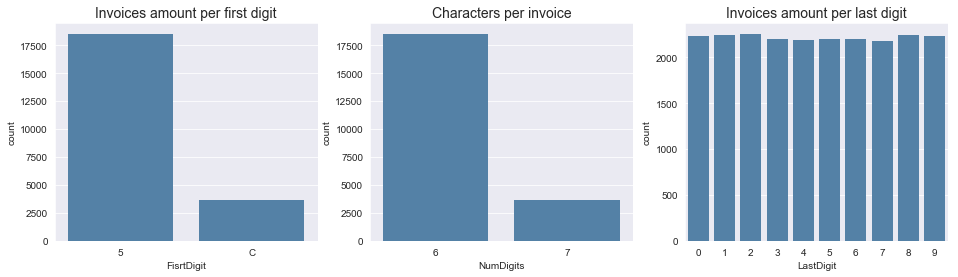

In [10]:
# DF with last digit count
last_digit = list_invoices.groupby(['LastDigit']).LastDigit.agg(['count']).reset_index()

# DF with fisrt digit count
first_digit = list_invoices.groupby(['FisrtDigit']).LastDigit.agg(['count']).reset_index()

# DF with number of digits count
num_digit = list_invoices.groupby(['NumDigits']).LastDigit.agg(['count']).reset_index()

# Make subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

# Make plots per first digit
ax1.set_title('Invoices amount per first digit', fontsize='14')
ax1 = sns.barplot(x="FisrtDigit", y="count", data=first_digit, color='steelblue', linewidth=0, ax=ax1)

# Make plots per Number of characters
ax2.set_title('Characters per invoice', fontsize='14')
ax2 = sns.barplot(x="NumDigits", y="count", data=num_digit, color='steelblue', linewidth=0, ax=ax2)

# Make plots per last digit
ax3.set_title('Invoices amount per last digit', fontsize='14')
ax3 = sns.barplot(x="LastDigit", y="count", data=last_digit, color='steelblue', linewidth=0, ax=ax3)

plt.show()


In [11]:
print('''Unique Invoices:''', UnicInvoiceNo)
print('''Invoices starts with "C":''', len(data.InvoiceNo[data.InvoiceNo.str.startswith('C')].unique()))
print('''Invoices starts with "C" and also negative:''', len(data.InvoiceNo[(data.InvoiceNo.str.startswith('C')) & (data.Quantity < 0)].unique()))

Unique Invoices: 25900
Invoices starts with "C": 3836
Invoices starts with "C" and also negative: 3836


**Conclusion**: All invoices that starts with "C" are invoices negatives, and the invoices that have 7 characters starts with "C" 

---
### 2.b.b- Explore "Description"  field

In [12]:
# Set on Lowercase the name of Products
data['Description'] = data['Description'].str.lower()


In [13]:
unique_products = list(data.Description[data.Description.notnull()].unique())

bag_of_words = []
for x in unique_products:
    bag_of_words = bag_of_words + x.split()

wordsFiltered = []
for w in bag_of_words:
    if w.lower() not in stopWords:
        wordsFiltered.append(w)

df_words = pd.DataFrame(wordsFiltered)
df_words.head()

,0
0,white
1,hanging
2,heart
3,t-light
4,holder


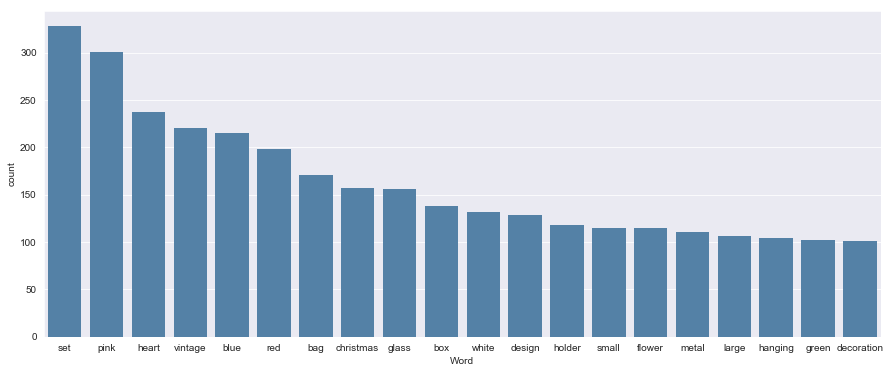

In [14]:
words_count = df_words[0].value_counts().reset_index()
words_count.columns = ['Word', 'count']

plt.figure(figsize=(15, 6))
sns.barplot(x="Word", y="count", data=words_count[words_count['count'] > 100], color='steelblue', linewidth=0)

---
### 2.b.c- Explore "Quantity"  field

In [15]:
data.Quantity.describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

In [16]:
# Make a DF with Quantity and frequency
quantitiy = data.Quantity.value_counts().reset_index()
quantitiy.columns = ['Quantity', 'count']

quantitiy.head()

,Quantity,count
0,1,148227
1,2,81829
2,12,61063
3,6,40868
4,4,38484


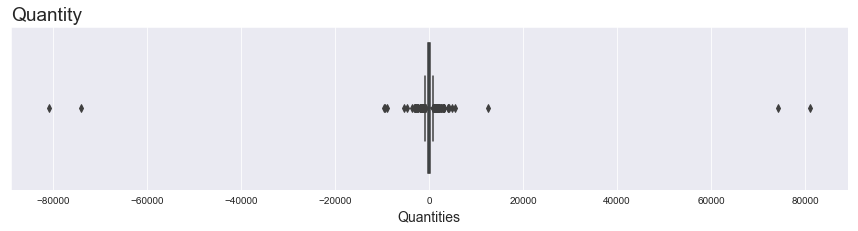

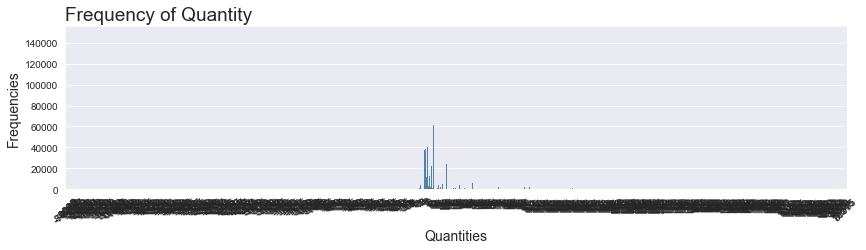

In [17]:
plt.figure(figsize=(15, 3))
sns.boxplot( x=quantitiy.Quantity)
plt.title("Quantity", loc="left", fontsize='19')
plt.xlabel("Quantities", fontsize='14')
plt.show()

plt.figure(figsize=(14, 3))
ax1 = sns.barplot(x="Quantity", y="count", data=quantitiy[(quantitiy['count'] > 0)], color='steelblue', linewidth=0)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

plt.title("Frequency of Quantity", loc="left", fontsize='19')
plt.xlabel("Quantities", fontsize='14')
plt.ylabel("Frequencies", fontsize='14')
plt.show()

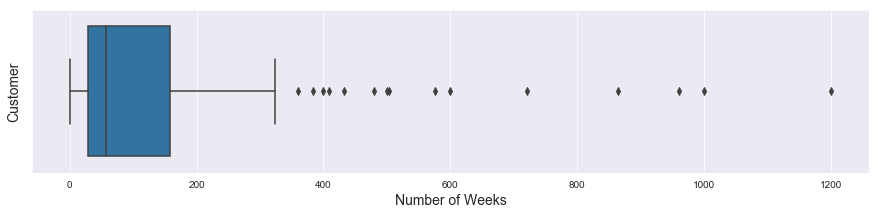

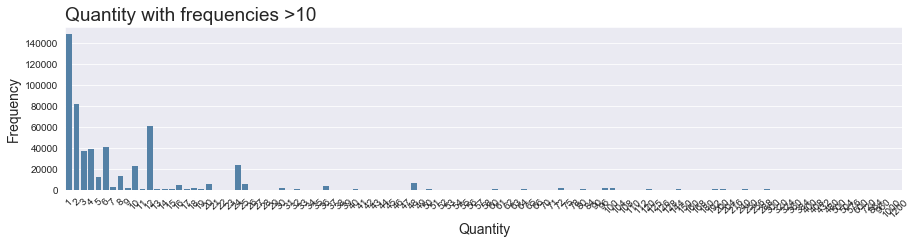

In [18]:
# Make DF where the amunt of 'Quantity' is greater than 0
quantity_Q = quantitiy[quantitiy.Quantity > 0].sort_values(by='Quantity')

# Q1 = quantity_Q['Quantity'].quantile(0.25)
# Q3 = quantity_Q['Quantity'].quantile(0.75)
# IQR = Q3 - Q1

# lower = Q1 - 1.5* IQR
# upper = Q3 + 1.5* IQR

# quantity_Q = quantity_Q.loc[(quantity_Q['Quantity'] > lower) & (quantity_Q['Quantity'] < upper)]

plt.figure(figsize=(15, 3))
sns.boxplot( x=quantity_Q.Quantity[(quantity_Q['count'] > 10)])

plt.title("", loc="left", fontsize='19')
plt.xlabel("Number of Weeks", fontsize='14')
plt.ylabel("Customer", fontsize='14')
plt.show()



plt.figure(figsize=(15, 3))
ax1 = sns.barplot(x="Quantity", y="count", data=quantity_Q[(quantity_Q['count'] > 10)], color='steelblue', linewidth=0)

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
plt.title("Quantity with frequencies >10", loc="left", fontsize='19')
plt.xlabel("Quantity", fontsize='14')
plt.ylabel("Frequency", fontsize='14')

plt.show()




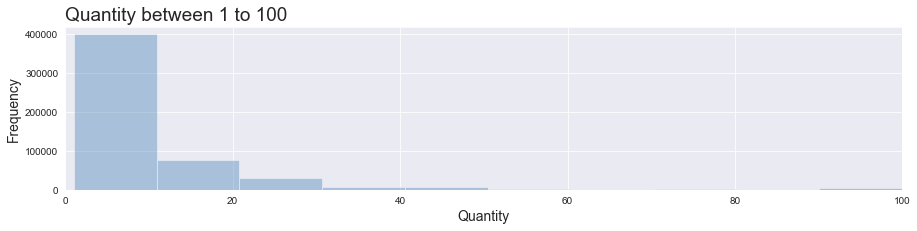

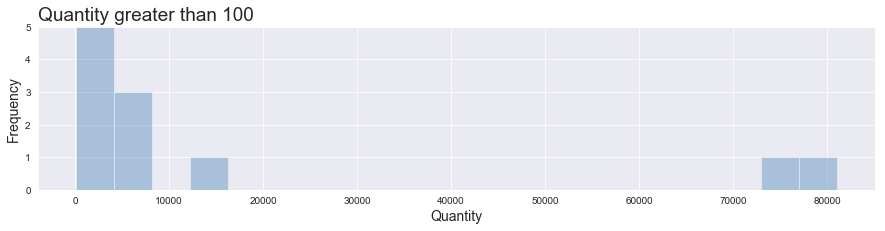

In [19]:
plt.figure(figsize=(15, 3))
sns.distplot(data.Quantity[(data.Quantity >0)&(data.Quantity <=100)], hist=True, kde=False, rug=False, bins=10, color='steelblue')

plt.title("Quantity between 1 to 100", loc="left", fontsize='19')
plt.xlabel("Quantity", fontsize='14')
plt.ylabel("Frequency", fontsize='14')
plt.xlim(0,100)

plt.show()

plt.figure(figsize=(15, 3))
sns.distplot(data.Quantity[(data.Quantity >100)], hist=True, kde=False, rug=False, bins=20, color='steelblue')
plt.ylim(0,5)

plt.title("Quantity greater than 100", loc="left", fontsize='19')
plt.xlabel("Quantity", fontsize='14')
plt.ylabel("Frequency", fontsize='14')

plt.show()

---
### 2.b.c- Explore "CustomerID"  field

In [20]:
# Visualizar registros con CustomerID nulos
nan_customers = data[(data.CustomerID.isnull())]
print('Logs where CustomerID is Nan:', len(nan_customers))
print('Logs where CustomerID is Nan, with negative Quantity:',len(nan_customers[nan_customers.Quantity <0]))
print('Logs where CustomerID is Nan, with positive Quantity',len(nan_customers[nan_customers.Quantity >0]))

Logs where CustomerID is Nan: 135080
Logs where CustomerID is Nan, with negative Quantity: 1719
Logs where CustomerID is Nan, with positive Quantity 133361


No hay una razon aparente del faltante de CustomerID's

In [21]:
# Make DataFrame with uniques CustomerID
list_CustomerID = data.groupby(['CustomerID']).CustomerID.agg(['count']).reset_index()
list_CustomerID['CustomerID'] = list_CustomerID.CustomerID.astype('int64')

# Create column with the first digit of invoices
list_CustomerID['FisrtDigit'] = list_CustomerID['CustomerID'].apply(lambda x: str(x)[:1])

# Create column with the last digit of invoices
list_CustomerID['LastDigit'] = list_CustomerID['CustomerID'].apply(lambda x: str(x)[-1:])

# Create column with the first digit of invoices
list_CustomerID['NumDigits'] = list_CustomerID['CustomerID'].apply(lambda x: len(str(x)))

list_CustomerID.head()

,CustomerID,count,FisrtDigit,LastDigit,NumDigits
0,12346,2,1,6,5
1,12347,182,1,7,5
2,12348,31,1,8,5
3,12349,73,1,9,5
4,12350,17,1,0,5


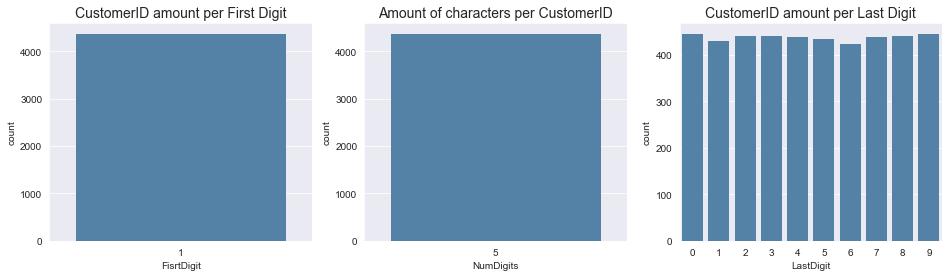

In [22]:
# DF with last digit count
last_digit = list_CustomerID.groupby(['LastDigit']).LastDigit.agg(['count']).reset_index()

# DF with fisrt digit count
first_digit = list_CustomerID.groupby(['FisrtDigit']).LastDigit.agg(['count']).reset_index()

# DF with number of digits count
num_digit = list_CustomerID.groupby(['NumDigits']).LastDigit.agg(['count']).reset_index()

# Make subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

# Make plots per first digit
ax1.set_title('CustomerID amount per First Digit', fontsize='14')
ax1 = sns.barplot(x="FisrtDigit", y="count", data=first_digit, color='steelblue', linewidth=0, ax=ax1)

# Make plots per Number of characters
ax2.set_title('Amount of characters per CustomerID', fontsize='14')
ax2 = sns.barplot(x="NumDigits", y="count", data=num_digit, color='steelblue', linewidth=0, ax=ax2)

# Make plots per last digit
ax3.set_title('CustomerID amount per Last Digit', fontsize='14')
ax3 = sns.barplot(x="LastDigit", y="count", data=last_digit, color='steelblue', linewidth=0, ax=ax3)

plt.show()


In [23]:
data[(data.Quantity < 0)].min()

InvoiceNo               536589
StockCode                10002
Quantity                -80995
InvoiceDate    1/10/2011 10:04
UnitPrice                    0
CustomerID               12346
Country              Australia
dtype: object

In [24]:
data[data.CustomerID == 12346]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,medium ceramic top storage jar,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom
61624,C541433,23166,medium ceramic top storage jar,-74215,1/18/2011 10:17,1.04,12346.0,United Kingdom


La revición del caso (con CustomerID = 12346) demuestra que tras una compra 'negativa', existe una compra anterior con el mismo valor en positivo. <br>
- _Conclusión: Se tratan de devoluciones o compras fallidas._

---
### _EDA Conclusion_

- **Datos Negativos**: Representan devoluciones de productos y/o facturas y se mantendrán.
- **CustomerID nullos**: Se eliminarán, ya que **_se trabajará en base a clientes_**.



---
## 3- Preprocessing (Nulls & Formats)

In [25]:
# Convertir InvoiceDate a formato fecha
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

In [26]:
# Eliminar CustomerID Nulos
data = data[~(data.CustomerID.isnull())]

In [27]:
# Visualizar el Dataset
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


---
# 3- Feature Engineering

### Campo InvoiceDate
Nuevas variables de Fecha:
- InvoiceYear
- InvoiceMonth
- InvoiceWeek
- InvoiceDay
- InvoiceHour
- InvoiceTimestamp

In [28]:
# Crear variable InvoiceYear
data['InvoiceYear'] = data['InvoiceDate'].apply(lambda x: x.year)

# Crear variable InvoiceMonth
data['InvoiceMonth'] = data['InvoiceDate'].apply(lambda x: x.month)

# Crear variable InvoiceWeek
data['InvoiceWeek'] = data['InvoiceDate'].apply(lambda x: x.week)

# Crear variable InvoiceDay
data['InvoiceDay'] = data['InvoiceDate'].apply(lambda x: x.day)

# Crear variable InvoiceHour
data['InvoiceHour'] = data['InvoiceDate'].apply(lambda x: x.hour)

# Crear variable InvoiceTimestamp
data['InvoiceTimestamp'] = data['InvoiceDate'].apply(lambda x: round(datetime.timestamp(x)))


### Campo TotalPrice

In [29]:
# Crear TotalPrice UnitPrice * Quantity
data['TotalPrice'] = data['UnitPrice'] * data['Quantity']


### First_Invoice

In [30]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYear,InvoiceMonth,InvoiceWeek,InvoiceDay,InvoiceHour,InvoiceTimestamp,TotalPrice
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,48,1,8,1291188360,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,48,1,8,1291188360,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,48,1,8,1291188360,22.00
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,48,1,8,1291188360,20.34
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,48,1,8,1291188360,20.34


# Plot

In [31]:
# Make DataFrame with Revenue and customers by Week
week_customers = pd.pivot_table(
    columns='InvoiceWeek', 
    data=data[data.InvoiceYear == 2011], 
    aggfunc={'TotalPrice': np.sum, 'CustomerID': 'nunique'})

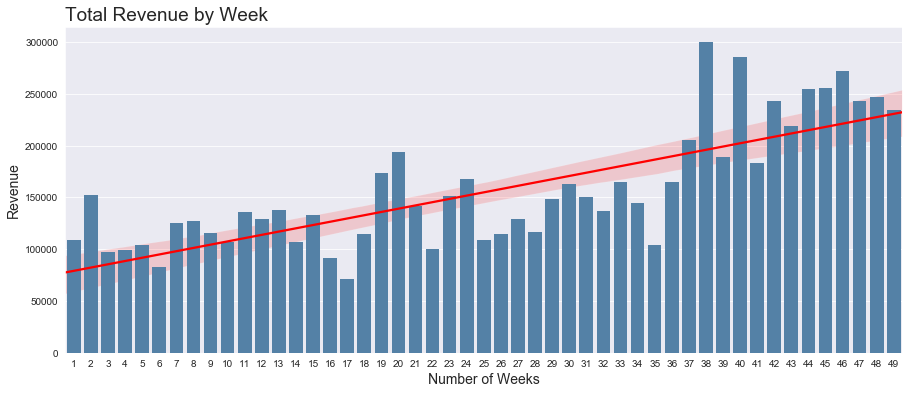

In [32]:
# Make BarPlot
plt.figure(figsize=(15, 6))
sns.barplot(x="InvoiceWeek", y="TotalPrice", data=week_customers.T.reset_index(), color='steelblue', linewidth=0)
sns.regplot(x='InvoiceWeek',y='TotalPrice',data=week_customers.T.reset_index(), fit_reg=True,scatter=False, color= 'red') 

# setup plot
plt.title("Total Revenue by Week", loc="left", fontsize='19')
plt.xlabel("Number of Weeks", fontsize='14')
plt.ylabel("Revenue", fontsize='14')
plt.show()

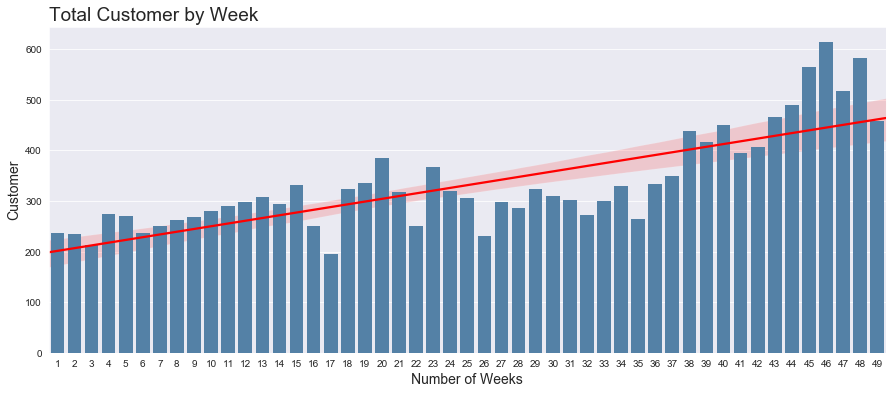

In [33]:
# Make BarPlot
plt.figure(figsize=(15, 6))
sns.barplot(x="InvoiceWeek", y="CustomerID", data=week_customers.T.reset_index(), color='steelblue', linewidth=0)
sns.regplot(x='InvoiceWeek',y='CustomerID',data=week_customers.T.reset_index(), fit_reg=True,scatter=False, color= 'red') 

# setup plot
plt.title("Total Customer by Week", loc="left", fontsize='19')
plt.xlabel("Number of Weeks", fontsize='14')
plt.ylabel("Customer", fontsize='14')
plt.show()

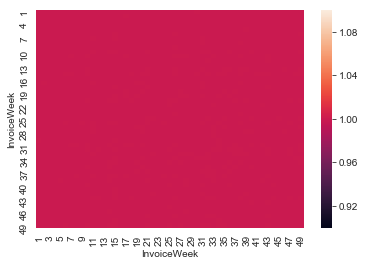

In [34]:
sns.heatmap(week_customers.corr())